 # BZCAT Study 

There is an association analysis run for each of the monthly models. One of the objectives of running all the months is to find transient sources, for which blazars are an obvious candidate. Here I examine all BZCAT associations, both for the 6-year source list, and for each of the 72 single-month sky models. The association analysis for each sky model has a special check for all sources which are associated with the BZCAT catalog. Given that AGN catalogs often have sources in common, this analysis searches the list of associations for each source to see if any, not necessariy the one with the highest probability, corresponds to BZCAT. All such are saved for later reference. 

The current catalog, [BZCAT5](http://www.asdc.asi.it/bzcat/), has 3561 entries.

This analysis uses both this information, and extracts the detailed monthly information for each 6-year source, to allow comparisons.

#### Load stuff

Read in the "bzcat_summary" files generated by the association analysis for each month, and for the 6-year model. Those files, indexed by the name, have the association info, the name of the 6-year source, and TS of the fit. 



In [32]:
%matplotlib inline
from IPython import display
from uw.like2.analyze import transientinfo as ti; reload(ti)
%time ta = ti.Analysis()

CPU times: user 1min 23s, sys: 5.9 s, total: 1min 29s
Wall time: 1min 29s


In [33]:
reload(ti)
si= ti.BZCATinfo(ta, quiet=True); ti.DateStamp()

loading SourceInfo with 1219 sources
Source S966-512 not detected in any month
Source P86Y0205 not detected in any month
Source P86Y1420 not detected in any month
277 monthly names are in the 6-year list of 584 names


This loaded the list of associations from the 6-year run.

## Study of Variability and Localization resolution with 6-year sources
First I examine the monthly fits for the 1219 6-year BZCAT-associated sources. It is interesting to apply the same analysis as for the pulsars, given that most AGNs are not constant. 

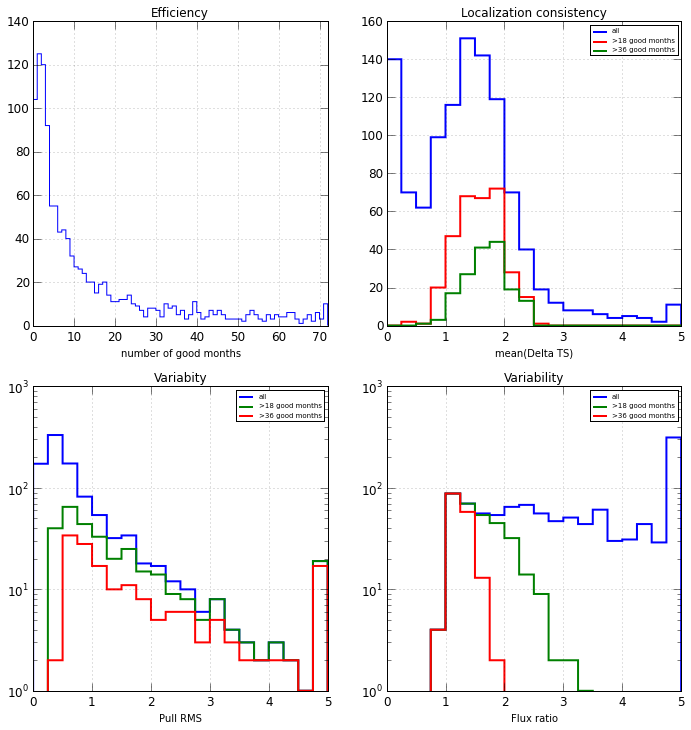

In [34]:
si.bzcat_plots();

The __upper left__ plot shows the monthly frequency distribution, depending on the efficiency and the flux distribution. In the subsequent histograms, I show the distribution for all, and subsets of having more than 18, and 36 monthly measurements.  The __upper right__ plot is a histogram of the means of the association TS values for the months. It is ideally 2.0. The __lower left__ plot is of the RMS of the pulls for the flux measuremnts. For a constant source,this should be 1.0.  In this case, the variability is an important factor. It is surprising that there are so many close to 1.0, however. The __lower right__ plot shows the ratio of the measured monthly flux to the 6-year average. This should be 1.0. For less than 100% efficiency, the selection effect biases it, but variability also affects this.

The next plot shows the association TS distribution for the 6-year measurements. The expected exponential is plotted.

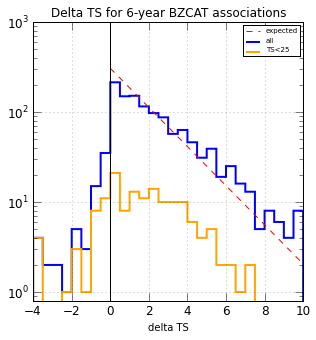

In [35]:
ti.delta_ts_figure(si.bz6,'Delta TS for 6-year BZCAT associations' );

Note the T<25 subset. For weak sources, statistical fluctions affect the measurment of the shape of the likelihood function, causing the deviation from the expected exponential, and the large negative tail. Also note that the slope of the exponential is not quite right: a fit to all AGN associations gives an error scaling factor of 1.07.

### Transient BZCAT associations
Now we turn to look at the BZCAT associations of the "transient" sources found in the monthly sky models. That is, the sources found by PGWAVE or the TS map analysis. 
I compare it with the set of names from the 6-year model.

Idealy, there should be no overlap, since the 6-year sources are input to the source finding procedure. This is not the case for two reasons:
1. The 6-year source was discarded by mistake
2. The new source is close enough to get associated; there is no check to require only one association with a given source.
The next plot shows the number of associations per month, and the subset which are not in the 6-year list:

The new associations are mostly detected in a single moonth. The following table compares the two sets. 

In [36]:
display.HTML(si.monthly_frequency_table())

,1,2,3,4,5,6,7,8,9,10,11,12,13
in 6y,202,36,21,8,4,2,1,0,0,0,1,0,0
new,262,39,4,1,0,0,0,1,0,0,0,0,0


Using the BZCAT list of sources has the benefit of easy access to the blazar type. For the "new" set, here is the integral distribution, and a table of the totals:

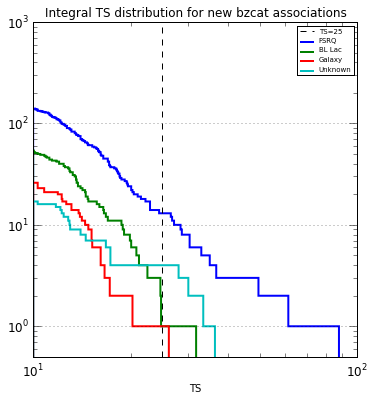

In [37]:
si.cumulative_ts();

In [38]:
display.HTML(si.agn_type_table())

,number,fraction (%)
BL Lac,67,21.8
FSRQ,186,60.6
Radio galaxy,32,10.4
unknown,22,7.2


The blazar classification is of course based on the radio properties, so the strong correlation is a good indicator that the associations are good. Since most of the TS values are small, we need to be careful to check for possible contamination of spurious sources.

The next plot is such a check, the distribution of the association likelihood. While clearly not consistent with the expected exponential, it is similar to the low-TS sources in the 6-year list.

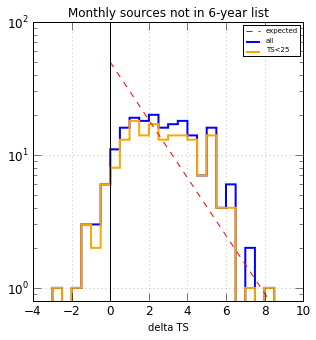

In [39]:
reload(ti)
# make a list of deltats for the new ones
newnames = set(si.bzdf[si.bzdf.notin6y].index)
d = dict()
for bzm in  si.bzm: #loop over months
    for name in set(bzm.index):#.intersection(newnames):
        if name not in si.bz6.index: continue
        rec = bzm.ix[name]
        if (rec.ts<10 or np.isnan(rec.ts) 
            or np.isnan(rec.deltats)): continue
        d[name]=dict(adeltats=rec.deltats,ts=rec.ts)
t = pd.DataFrame(d).T
ti.delta_ts_figure(t, title='Monthly sources not in 6-year list');

## Check all associations
The BZCAT study only looked at that subset of the associations. For completeness, here is a check for all, with a look at the association likelihood.

In [40]:
t = []
for i,mi in enumerate(si.ta.monthinfo):
    t.append(mi.df[(mi.df.transient) & (mi.df.aprob>0.8)&(mi.df.locqual<8)
                  & (np.abs(mi.df.glat)>10) &(mi.df.ts>10)])
tdf =pd.concat(t) 
cats =set(tdf.acat)
ncat = dict()
for cat in cats:
    n = sum(tdf.acat==cat)
    if n>2: ncat[cat] = n 
pd.DataFrame(ncat, index=['number associated']).T

,number associated
agn,9
bllac,90
bzcat,503
cgrabs,318
crates,553
pulsar_big,39
pulsar_lat,35
qso,82
starbursts,13


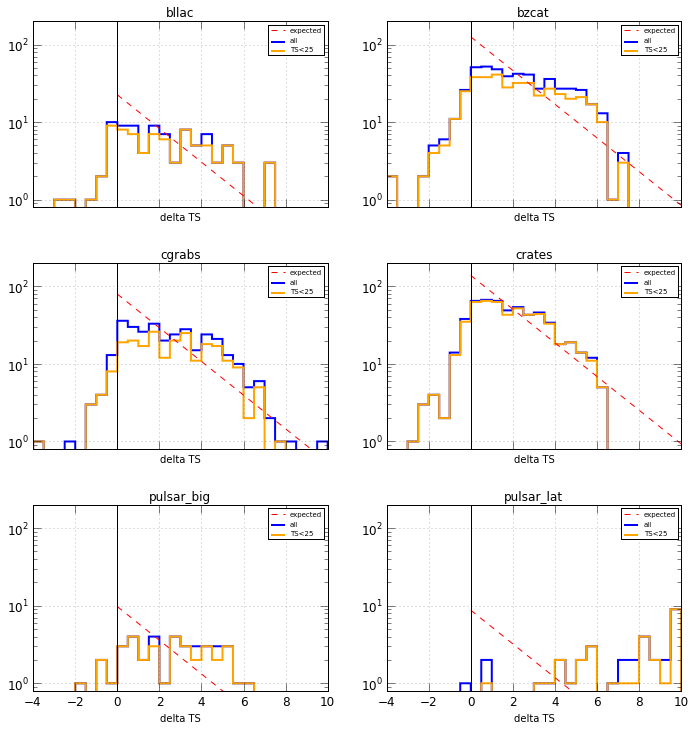

In [41]:
reload(ti)
fig, axx = plt.subplots(3,2, sharex=True, figsize=(12,12))
plt.subplots_adjust(hspace=0.3)
for ax,cat in zip(axx.flatten(), 'bllac bzcat cgrabs crates pulsar_big pulsar_lat'.split()):
    ti.delta_ts_figure(tdf[tdf.acat==cat], ax=ax, title=cat, ymax=200)

In this case, the "bzcat" entries are only those for which it had the highest probability. Of interest is are the pulsar_lat entries, which are clearly incorrect, as the pulsars are in the model. But the values are consistent with a few that I explictly looked at, sources that were near the actual pulsar, and close enough to also get tagged. 

## Check list against the LAC  BZCAT associations
This uses a FITS file provided by Betta, with combined associations from the
1LAC, 2LAC and 3LAC catalogs.

In [42]:
import pyfits
path = '/nfs/farm/g/glast/u/burnett/notebooks/'
f = pyfits.open(path+'ALL-LAC-bzcat5.fits')
lacnames = set(f[1].data['Source name'])

### Compare the sets: xLAC, 6-year, and monthly

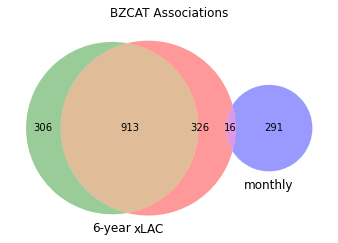

In [43]:
from matplotlib_venn import venn3
bz6names = set(si.bz6.index); 
found_in_months= set(si.bzdf.index[si.bzdf.notin6y]); 
v=venn3( [lacnames, bz6names, found_in_months ], ('xLAC', '6-year', 'monthly'),)
plt.title('BZCAT Associations');

In [44]:
# write out a file with the monthly having BZCAT associations
si.bzdf[si.bzdf.notin6y]['monthnumber msname ts tsmax months'.split()].to_csv('new_monthly_bzcat.csv')

## Examine the full BZCAT list
First, look at the frequency of spectral types

In [45]:
bzcat = ti.BZCAT()
bzcat.type_frequency()

,frequency,fraction (%)
spectral type,,
BL Lac,1151,32.3
FSRQ,1909,53.6
radio galaxy,274,7.7
unknown,227,6.4


In [46]:
bzcat.cat['xray']= bzcat.cat['X-ray flux0.1-2.4 keV(1.e-12 cgs)']

In [47]:
bzcat.describe()

,RA (J2000.0),Dec (J2000.0),LII,BII,Rmag,Flux density 1.4/0.843GHz(mJy),Flux density143GHz(mJy),X-ray flux0.1-2.4 keV(1.e-12 cgs),Comment on rmag,Commenton radio flux,Fermi flux1-100 GeV(ph/cm2/s),z,xray
count,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561,3561,3.561000e+03,3561.000000,3561.000000
mean,176.770906,8.367145,169.438717,8.513530,18.187869,420.442937,132.194047,1.045364,0,0,5.984555e-10,0.878528,1.045364
std,99.277203,36.195893,96.801015,46.017991,2.165484,1324.446012,762.875836,6.823494,0,0,2.746581e-09,0.874974,6.823494
min,0.084960,-86.250500,0.340000,-88.669998,0.000000,0.000000,0.000000,0.000000,False,False,0.000000e+00,0.000000,0.000000
25%,102.055920,-17.420310,86.430000,-34.189999,17.400000,54.000000,0.000000,0.000000,0,0,0.000000e+00,0.138000,0.000000
50%,178.071710,9.011190,167.600006,22.040001,18.500000,179.000000,0.000000,0.210000,0,0,0.000000e+00,0.636000,0.210000
75%,246.607710,37.768690,243.740005,47.500000,19.299999,439.000000,0.000000,0.670000,0,0,4.000000e-10,1.391000,0.670000
max,359.897880,86.205920,359.940002,87.570000,24.400000,54992.000000,27943.000000,324.000000,False,False,9.650000e-08,6.802000,324.000000


### Correlate with the LAC,  6-month and monthly lists
Then tabulate the high-z sources

In [48]:
bzcatnames = list(bzcat.cat['Source name'])
inbz = np.array([ name in bz6names         for name in bzcatnames] ) 
minbz =np.array([ name in found_in_months  for name in bzcatnames] )
lacdfsel = np.array([ name in lacnames  for name in bzcatnames] )
display.HTML(
    '<h4>xLAC</h4>'
    + bzcat.cat[['Source name','z']][lacdfsel & (bzcat.cat.z>3)].to_html()
    + '<h4>6-year</h4>'
    + bzcat.cat[['Source name','z']][inbz & (bzcat.cat.z>3)].to_html()
    +'<h4>Monthly</h4>'
    + bzcat.cat[['Source name','z']][minbz & (bzcat.cat.z>3)].to_html()
    )

,Source name,z
553,5BZQJ0339-0133,3.197
788,5BZQJ0539-2839,3.104
1041,5BZQJ0805+6144,3.033
2255,5BZQJ1405+0415,3.208
2664,5BZQJ1624-0649,3.307
,Source name,z
788,5BZQJ0539-2839,3.104
959,5BZQJ0733+0456,3.010
2221,5BZQJ1354-0206,3.716
2341,5BZQJ1429+5406,3.013


##  Histograms of the redshift and fluxes in X-ray, optical, and radio

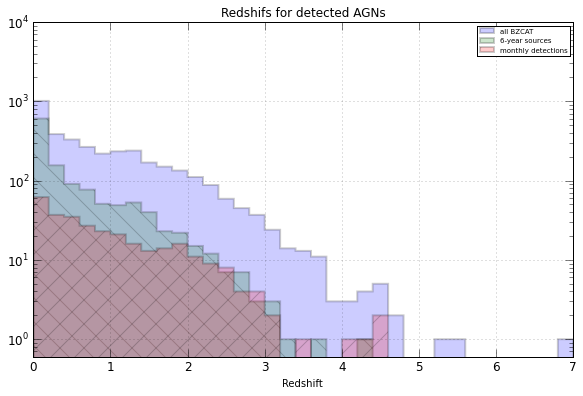

In [49]:
def bzcat_hist(quantity, bins,
               label=None, title=''):
    if label is None: label=quantity
    fig, ax = plt.subplots(figsize=(10,6))
    hist_kw = dict(bins=bins,  
                   histtype='stepfilled',alpha=0.2, lw=2, log=True)
    rs = np.array(bzcat.cat[quantity].clip(bins[0],bins[-1]),float)
    ax.hist(rs, label='all BZCAT', **hist_kw);
    ax.hist(rs[inbz], label='6-year sources',hatch='\\', **hist_kw)
    ax.hist(rs[minbz], label='monthly detections', hatch='/', **hist_kw)
    ax.grid(True, alpha=0.5)
    plt.setp(ax, ylim=(0.6,None), xlabel=label, title=title)
    ax.legend(loc='best');
bzcat_hist('z',  bins=np.linspace(0,7,36), label='Redshift',
           title='Redshifs for detected AGNs')

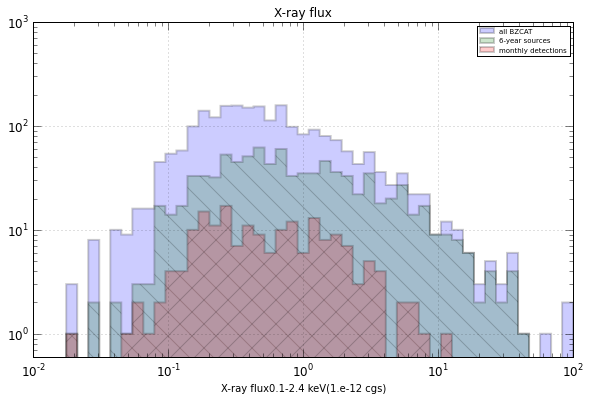

In [50]:
bzcat_hist('X-ray flux0.1-2.4 keV(1.e-12 cgs)', bins=np.logspace(-2,2), 
            title='X-ray flux')
plt.setp(plt.gca(), xscale='log');

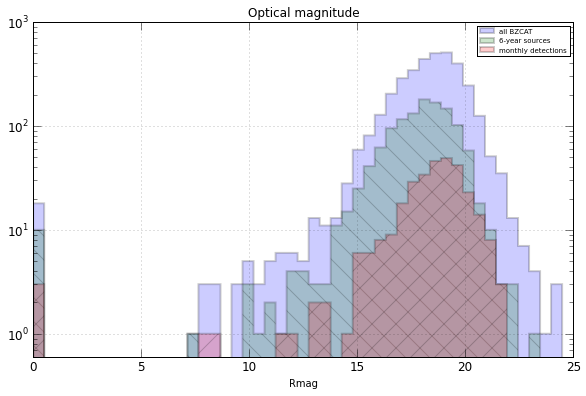

In [51]:
bzcat_hist('Rmag', bins=np.linspace(0,25), title='Optical magnitude')

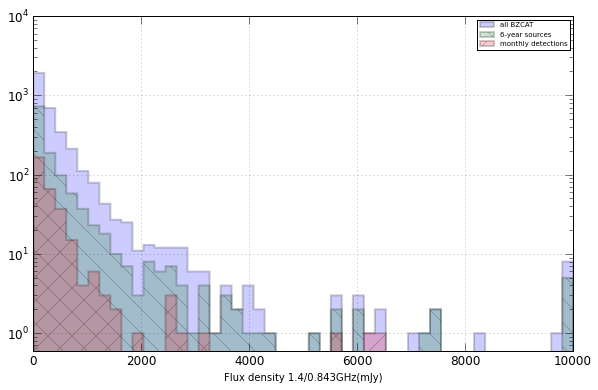

In [52]:
bzcat_hist('Flux density 1.4/0.843GHz(mJy)', bins=np.linspace(0,10000))

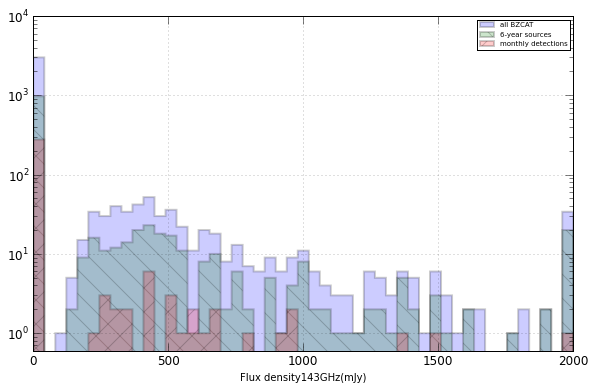

In [53]:
bzcat_hist('Flux density143GHz(mJy)', bins=np.linspace(0,2000))

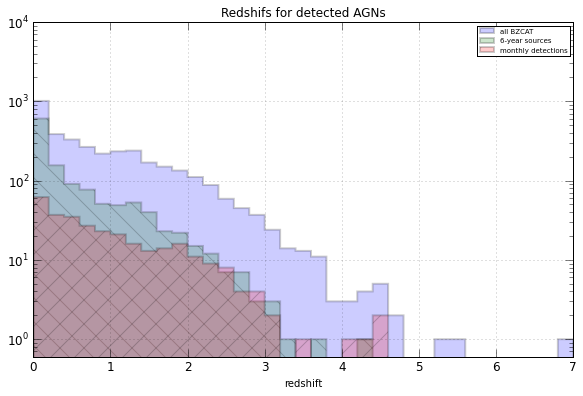

In [54]:
fig, ax = plt.subplots(figsize=(10,6))
hist_kw = dict(bins=np.linspace(0,7,36), histtype='stepfilled',alpha=0.2, lw=2, log=True)
rs = np.array(bzcat.cat.z,float)
ax.hist(rs, label='all BZCAT', **hist_kw);
ax.hist(rs[inbz], label='6-year sources',hatch='\\', **hist_kw)
ax.hist(rs[minbz], label='monthly detections', hatch='/', **hist_kw)
ax.grid(True, alpha=0.5)
plt.setp(ax, ylim=(0.6,None), xlabel='redshift', title='Redshifs for detected AGNs')
ax.legend();

## Examine the z>4 sources

redshift, source(s),  month(s), ts: 4.413 ['TSh26-1000'] [26] [ 12.8]
Failed gti check:
  ltcube: Gti: 491 intervals from 305080000 to 307710000, on time 1975013 
 binfile: Gti: 498 intervals from 305080019 to 307709970, on time 1974754
41 total sources: 0 extended, 3 global
setting size from 3.08 to 2.0
TSplot: filling 225 pixels (size=2.00, npix=15)...


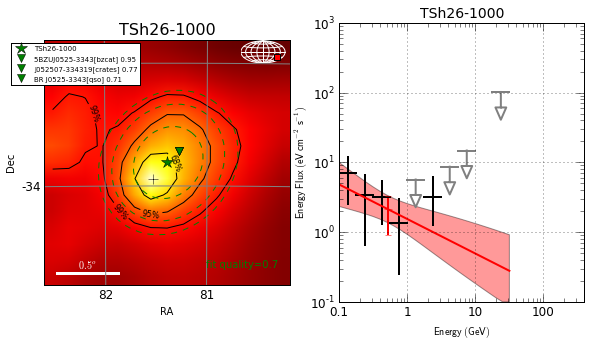

In [65]:
reload(ti)
ti.source_plots(si,bzcat, '5BZUJ0525-3343');

redshift, source(s),  month(s), ts: 4.575 ['TSh33-0387'] [33] [ 9.4]
Failed gti check:
  ltcube: Gti: 522 intervals from 323490000 to 326119766, on time 1896483 
 binfile: Gti: 529 intervals from 323490009 to 326119766, on time 1896263
38 total sources: 0 extended, 3 global
TSplot: filling 225 pixels (size=0.74, npix=15)...


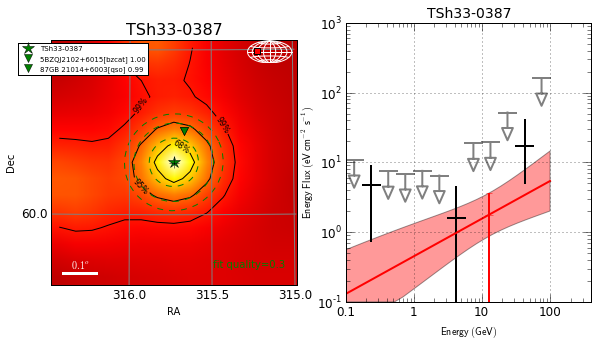

In [66]:
ti.source_plots(si, bzcat, '5BZQJ2102+6015');

redshift, source(s),  month(s), ts: 4.217 ['TSh25-0245' 'TSh61-0269'] [25 61] [ 15.7  11.4]
Failed gti check:
  ltcube: Gti: 470 intervals from 302450000 to 305080000, on time 2207261 
 binfile: Gti: 478 intervals from 302450004 to 305079989, on time 2207006
37 total sources: 0 extended, 3 global
TSplot: filling 225 pixels (size=0.93, npix=15)...


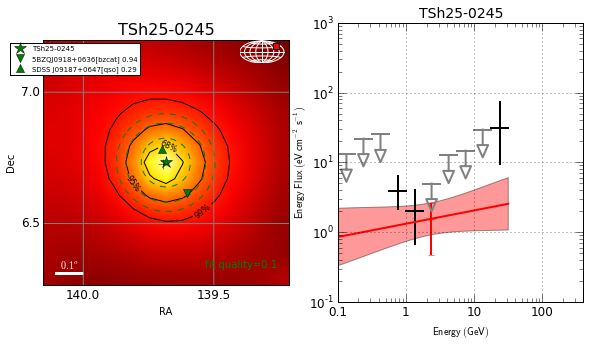

In [67]:
ti.source_plots(si, bzcat, '5BZQJ0918+0636');

redshift, source(s),  month(s), ts: 4.0 ['TSh15-1330'] [15] [ 20.]
Failed gti check:
  ltcube: Gti: 503 intervals from 276150000 to 278780000, on time 2144640 
 binfile: Gti: 511 intervals from 276150026 to 278779987, on time 2144361
41 total sources: 0 extended, 3 global
TSplot: filling 225 pixels (size=1.96, npix=15)...


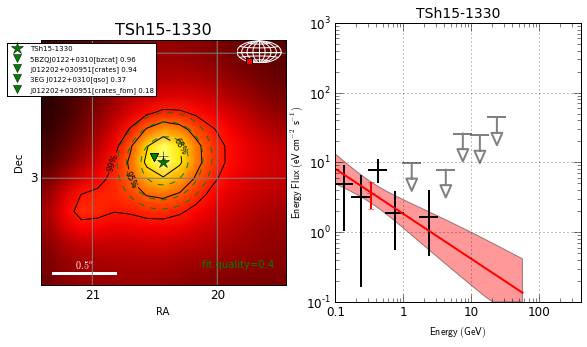

In [68]:
ti.source_plots(si, bzcat, '5BZQJ0122+0310');

In [69]:
pd.DataFrame({'xLAC':3.3, '6-year':4.3, 'monthly':4.6}, index=['max z'] ).T

,max z
6-year,4.3
monthly,4.6
xLAC,3.3


## The 6-year z=4.3 source

In [70]:
si.bz6.ix['5BZQJ1510+5702']

ang        0.0507517
dec         57.04539
deltats    0.6714376
locqual         1.65
ra          227.5122
sname       P86Y3410
ts          47.10248
type               Q
Name: 5BZQJ1510+5702, dtype: object

In [71]:
sname = 'P86Y4310'
import pickle
os.chdir(os.path.expandvars('$FERMI/skymodels/P301_6years/uw972'))
p=pickle.load(open('sources.pickle'))

In [72]:
from uw.like2 import process
r = process.Process('.', quiet=True)
r.setup_roi(int(p.ix[sname].roiname[-4:]))

Failed gti check:
  ltcube: Gti: 37884 intervals from 239557417 to 428689918, on time 150902856 
 binfile: Gti: 38437 intervals from 239557417 to 428689918, on time 150881091
222 total sources: 1 extended, 3 global


TSplot: filling 225 pixels (size=0.53, npix=15)...


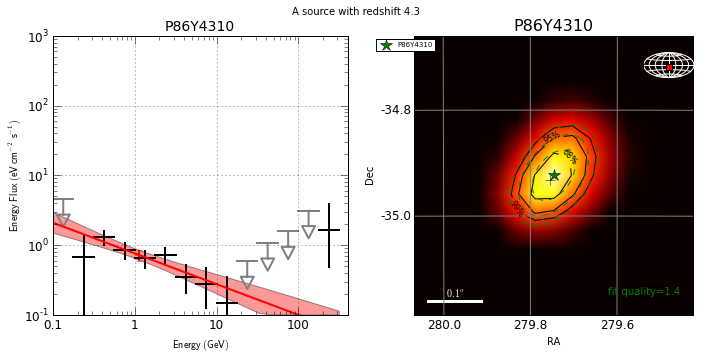

In [73]:
fig, axx = plt.subplots(1,2, figsize=(12,5))
r.plot_sed(sname, axes=axx[0]);r.plot_tsmap(sname,axes=axx[1]);
fig.suptitle('A source with redshift 4.3')

In [74]:
bzcat.cat.ix[bzcatnames.index('5BZQJ1510+5702')]

Source name                                    5BZQJ1510+5702
Other name                                   GB 1508+5714    
RA (J2000.0)                                         227.5122
Dec (J2000.0)                                        57.04539
LII                                                     93.25
BII                                                     51.34
Redshift                                              4.313  
Rmag                                                     20.3
Source classification                QSO RLoud flat radio sp.
Flux density 1.4/0.843GHz(mJy)                            203
Flux density143GHz(mJy)                                     0
X-ray flux0.1-2.4 keV(1.e-12 cgs)                           0
Comment on redshift                                         .
Comment on rmag                                         False
Commenton radio flux                                    False
Fermi flux1-100 GeV(ph/cm2/s)                               0
z       